In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
from utils.utils import MyDataset, show_image, visualise_output
import sys
sys.path.append("..")
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy

In [2]:
dataset = MyDataset(root='../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float))

In [4]:
latent_dims = 256
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
net = FireAutoencoder(capacity, input_size, latent_dims, sigmoid)
net.load_state_dict(torch.load(f'weights/v1/homo_2_sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.9, 0.05, 0.05])

In [6]:
batch = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch, shuffle=False)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=False)

In [7]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [8]:
all_images, all_r = next(iter(full_loader))

In [9]:
embeddings = net.encode(all_images)

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np

class ANN(nn.Module):
    def __init__(self, latent_dims, capacity):
        super(ANN, self).__init__()
   
        # Reward predictor:
        self.fc_r1 = nn.Linear(in_features=latent_dims, out_features=capacity)
        self.fc_r2 = nn.Linear(in_features=capacity, out_features=capacity//2)
        self.fc_r3 = nn.Linear(in_features=capacity//2, out_features=capacity//4)
        self.fc_r4 = nn.Linear(in_features=capacity//4, out_features=1)

    
    def forward(self, x):
        h1 = F.relu(self.fc_r1(x))
        h2 = F.relu(self.fc_r2(h1))
        h3 = F.relu(self.fc_r3(h2))
        reward = self.fc_r4(h3)
        return reward


In [14]:
reward_ann = ANN(latent_dims,capacity=64)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(reward_ann.parameters(), lr = 0.0001)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reward_ann.to(device)
epochs = 50
training_loss = []
validation_loss = []
for epoch in range(epochs):
    n = 0
    m = 0
    epoch_loss = 0
    val_epoch_loss = 0
    for x, r in train_loader:
        embedding = net.encode(x)
        r = r.to(device)
        output = reward_ann(embedding)
        loss = criterion(output.squeeze(), r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n += 1
    
    for y, r in validation_loader:
        embedding = net.encode(y)
        r = r.to(device)
        output = reward_ann(embedding)
        val_loss = criterion(output.squeeze(),r)
        optimizer.zero_grad()
        val_epoch_loss += val_loss.item()
        m+=1
    training_loss.append(epoch_loss/n)
    validation_loss.append(val_epoch_loss/m)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, epochs, val_loss.item()))

Epoch [1/50], Loss: 553303.5000
Epoch [1/50], Validation Loss: 600717.2500
Epoch [2/50], Loss: 279086.8125
Epoch [2/50], Validation Loss: 248029.7969
Epoch [3/50], Loss: 87168.4844
Epoch [3/50], Validation Loss: 97320.7031
Epoch [4/50], Loss: 57182.9023
Epoch [4/50], Validation Loss: 81424.2344
Epoch [5/50], Loss: 39405.8164
Epoch [5/50], Validation Loss: 61906.6562


KeyboardInterrupt: 

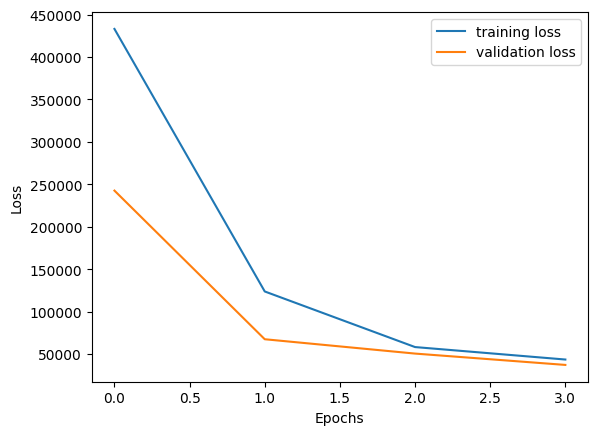

In [17]:
plt.ion()
fig = plt.figure()
plt.plot(training_loss[1:], label='training loss')
plt.plot(validation_loss[1:], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
embeddings = net.encode(all_images)

In [19]:
with torch.no_grad():
    rewards = reward_ann(embeddings)

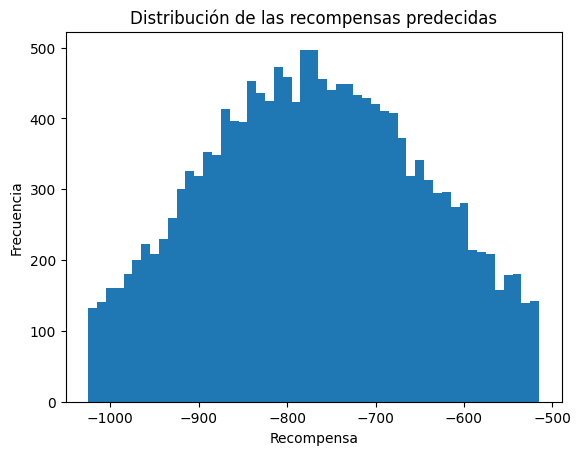

In [20]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards.squeeze().numpy(), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
#plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [21]:
def ann(x):
    return reward_ann(torch.from_numpy(x).float()).detach().numpy()

In [22]:
res = scipy.optimize.minimize(ann, x0=np.zeros(latent_dims))

In [23]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -559.7499389648438
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 257
     njev: 1

In [24]:
minimum = torch.from_numpy(res.x)

In [25]:
net.float()

FireAutoencoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=6400, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [26]:
solution = net.decode(minimum.float().unsqueeze(0))

In [27]:
solution

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [28]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

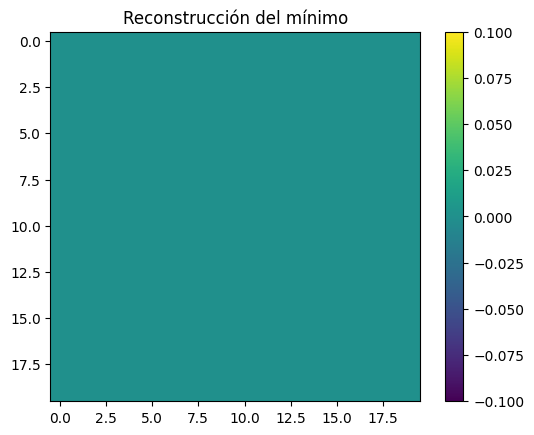

In [29]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        #plt.savefig(f"linear_regresion/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [30]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.